In [1]:
import re
import math
import time
import warnings
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## for preprocessing
from sklearn.preprocessing import StandardScaler

## for classification
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import SGDClassifier

## for metrics
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

## for bag-of-words / Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for universal sentence encoder
import tensorflow_hub as hub

## Plotting tools
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

## dump
import joblib

In [2]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Chargement du jeu de données

In [3]:
data = pd.read_pickle('df_save.pkl')  

In [4]:
data.shape

(10243, 36)

In [5]:
data.columns

Index(['text', 'list_tokens', 'str_tokens', 'Dominant_Topic',
       'Perc_Contribution', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
       'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15',
       'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21',
       'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27',
       'topic_28', 'topic_29', 'Tags_list'],
      dtype='object')

# Split

In [6]:
print('Split Dataset')
print('---------------------------------------------------------')
X_train, X_test = train_test_split(data, random_state=0, test_size=0.2)
print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))

Split Dataset
---------------------------------------------------------
X_train: (8194, 36)
X_test: (2049, 36)


In [7]:
y_train = X_train[['Tags_list']]
y_test = X_test[['Tags_list']]
print('y_train: ' + str(y_train.shape))
print('y_test: ' + str(y_test.shape))

y_train: (8194, 1)
y_test: (2049, 1)


# Target encoder

In [8]:
mlb = MultiLabelBinarizer()

In [9]:
y_train = mlb.fit_transform(y_train.Tags_list)

In [10]:
y_test = mlb.transform(y_test.Tags_list)

# Extraction de tags

In [11]:
def check_overfitting(model, X_train, limit):
    grid = GridSearchCV(model,
                        param_grid={},
                        scoring='f1_samples',
                        verbose=1,
                        cv=5,
                        n_jobs=-1,
                        return_train_score=True,
                        refit=True)
    
    grid.fit(X_train, y_train)
    train_score = grid.cv_results_['mean_train_score'][0]
    test_score = grid.cv_results_['mean_test_score'][0]

    print('train_score:', train_score)
    print('test_score:', test_score)
    print('')

    if (train_score - test_score) <= limit:
        print('model is not ovefitting')
    else:
        print('model is ovefitting')
        raise

In [12]:
eval_acc = {}
eval_jac = {}
eval_f1 = {}

def evaluation(case, y_true, y_pred, mlb):
    global eval_acc, eval_f1
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:",  round(accuracy,2))
    
    # jacard
    jacard = jaccard_score(y_true, y_pred, average='samples')
    print('Jacard:', round(jacard,2)) 
    
    # f1
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
    print('F1:', round(f1,2)) 
    
    eval_acc[case] = accuracy    
    eval_jac[case] = jacard
    eval_f1[case] = f1

## Approche semi-supervisée

In [13]:
X_train_semi = X_train.loc[:, (X_train.columns != 'text') &
                              (X_train.columns != 'list_tokens') &
                              (X_train.columns != 'str_tokens') &
                              (X_train.columns != 'Tags_list')
                           ]
X_test_semi = X_test.loc[:, (X_test.columns != 'text') &
                            (X_test.columns != 'list_tokens') &
                            (X_test.columns != 'str_tokens') &
                            (X_test.columns != 'Tags_list')
                         ]
print('X_train_semi: ' + str(X_train_semi.shape))
print('X_test_semi: ' + str(X_test_semi.shape))

X_train_semi: (8194, 32)
X_test_semi: (2049, 32)


In [14]:
lda = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', ClassifierChain(SGDClassifier(
        loss='squared_hinge', alpha=1e-2, max_iter=10, early_stopping=True)))
])

In [15]:
check_overfitting(lda, X_train_semi, 0.1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
train_score: 0.17494441332601146
test_score: 0.17312517235495822

model is not ovefitting


In [16]:
lda.fit(X_train_semi, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ClassifierChain(base_estimator=SGDClassifier(alpha=0.01,
                                                              early_stopping=True,
                                                              loss='squared_hinge',
                                                              max_iter=10)))])

In [17]:
predicted_semi = lda.predict(X_test_semi)

In [18]:
evaluation('lda', y_test, predicted_semi, mlb)

Accuracy: 0.07
Jacard: 0.16
F1: 0.19


## Approche supervisée

In [19]:
nb_features = 100

### Bag of words

In [20]:
X_train_bow = X_train.str_tokens
X_test_bow = X_test.str_tokens

In [21]:
bow = Pipeline([('bow', CountVectorizer(max_features=nb_features, ngram_range=(1, 2))),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', ClassifierChain(SGDClassifier(
                    loss='squared_hinge', alpha=1e-2, max_iter=10, early_stopping=True)))
                ])

In [22]:
check_overfitting(bow, X_train_bow, 0.1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
train_score: 0.32876320527131286
test_score: 0.30185453827018077

model is not ovefitting


In [23]:
bow.fit(X_train_bow, y_train)

Pipeline(steps=[('bow', CountVectorizer(max_features=100, ngram_range=(1, 2))),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 ClassifierChain(base_estimator=SGDClassifier(alpha=0.01,
                                                              early_stopping=True,
                                                              loss='squared_hinge',
                                                              max_iter=10)))])

In [24]:
y_pred_bow = bow.predict(X_test_bow)

In [25]:
evaluation('bow', y_test, y_pred_bow, mlb)

Accuracy: 0.11
Jacard: 0.25
F1: 0.3


### Tf-Idf

In [26]:
X_train_tfidf = X_train.str_tokens
X_test_tfidf = X_test.str_tokens

In [27]:
tfidf = Pipeline([('tfidf', TfidfVectorizer(max_features=nb_features, ngram_range=(1, 2))),
                  ('scaler', StandardScaler(with_mean=False)),
                  ('clf', ClassifierChain(SGDClassifier(
                      loss='squared_hinge', alpha=1e-2, max_iter=10, early_stopping=True)))
                  ])

In [28]:
check_overfitting(tfidf, X_train_tfidf, 0.1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
train_score: 0.35700300965294895
test_score: 0.32846678586851163

model is not ovefitting


In [29]:
tfidf.fit(X_train_tfidf, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=100, ngram_range=(1, 2))),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 ClassifierChain(base_estimator=SGDClassifier(alpha=0.01,
                                                              early_stopping=True,
                                                              loss='squared_hinge',
                                                              max_iter=10)))])

In [30]:
y_pred_tfidf = tfidf.predict(X_test_tfidf)

In [31]:
evaluation('tfidf', y_test, y_pred_tfidf, mlb)

Accuracy: 0.14
Jacard: 0.28
F1: 0.34


# Résultat final

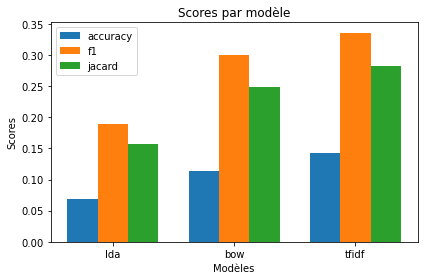

In [32]:
ind = np.arange(3) 
width = 0.25       
plt.bar(ind, eval_acc.values(), width, label='accuracy')
plt.bar(ind + width, eval_f1.values(), width, label='f1')
plt.bar(ind + (width * 2), eval_jac.values(), width, label='jacard')

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Scores par modèle')

plt.xticks(ind + width, ['lda', 'bow', 'tfidf'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('test_result', dpi=100)
plt.show()